In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [14]:
bucket='sagemaker-ml-circuit-breaker'
data_key = 'Bibit_Aggregated_Data_week_30s.csv'

#Define IAM role
import boto3
import re 
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role
print(role)

data_location = 's3://{}/{}'.format(bucket, data_key)
print(data_location)
df = pd.read_csv(data_location)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print(df)

<function get_execution_role at 0x7f7ae80570d0>
s3://bucket/Data_week_30s.csv
                              _time        b  Request  Timeout
0      2020-06-08T00:00:00.000+0000  1584.800000      116        0
1      2020-06-08T00:00:30.000+0000  1474.000000      172        0
2      2020-06-08T00:01:00.000+0000  1614.600000      198        0
3      2020-06-08T00:01:30.000+0000  1614.600000      215        0
4      2020-06-08T00:02:00.000+0000  1500.000000      192        0
5      2020-06-08T00:02:30.000+0000  1592.000000      188        0
6      2020-06-08T00:03:00.000+0000  1573.500000      178        0
7      2020-06-08T00:03:30.000+0000  1569.000000      205        0
8      2020-06-08T00:04:00.000+0000  1548.200000      195        0
9      2020-06-08T00:04:30.000+0000  1437.700000      199        0
10     2020-06-08T00:05:00.000+0000  1623.000000      236        0
11     2020-06-08T00:05:30.000+0000  1593.400000      238        0
12     2020-06-08T00:06:00.000+0000  1579.000000      2

In [15]:
df.columns = ['time', 'latency', 'request', 'timeout']
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20160 entries, 0 to 20159
Data columns (total 4 columns):
time       20160 non-null object
latency    20160 non-null float64
request    20160 non-null int64
timeout    20160 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 630.1+ KB


,latency,request,timeout
count,20160.000000,20160.000000,20160.000000
mean,1673.903981,370.321081,0.443849
std,1880.921696,204.513930,4.931277
min,1176.600000,57.000000,0.000000
25%,1437.700000,195.000000,0.000000
50%,1533.000000,356.000000,0.000000
75%,1616.401563,499.000000,0.000000
max,30051.233330,1523.000000,94.000000


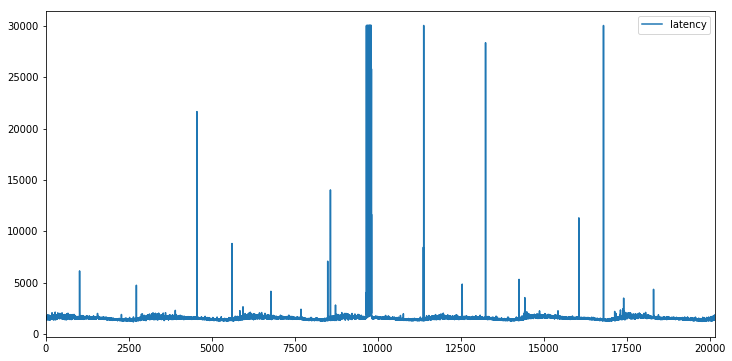

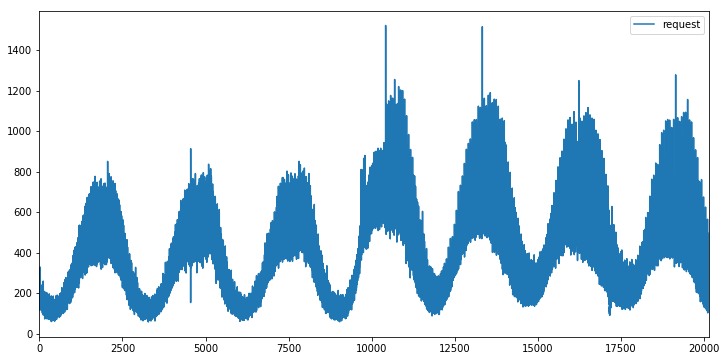

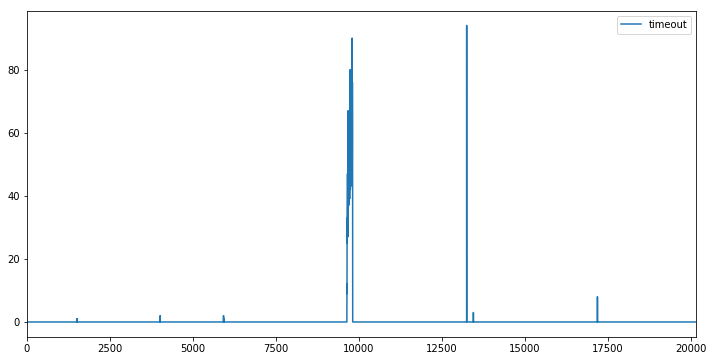

In [16]:
df.plot( y='latency', figsize=(12,6))
df.plot( y='request', figsize=(12,6))
df.plot( y='timeout', figsize=(12,6))

In [17]:
#cross validation
data = df[['latency', 'request','timeout']]
data.head()
train_data, test_data = train_test_split(data, test_size=0.4, random_state=0)

# Pre-processing

StandardScaler(copy=True, with_mean=True, with_std=True)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ec2-user/anaconda3/env

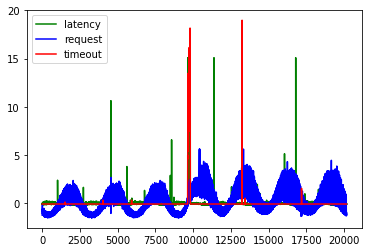

In [18]:
scaler = StandardScaler()
print(scaler)
np_scaled = scaler.fit_transform(data)
np_scaled_tr = scaler.fit_transform(train_data)
np_scaled_te = scaler.fit_transform(test_data)
X_train = pd.DataFrame(np_scaled_tr)
X_test = pd.DataFrame(np_scaled_te)
data = pd.DataFrame(np_scaled)

data.columns = ['latency', 'request', 'timeout']
X_train.columns = ['latency', 'request', 'timeout']
X_test.columns = ['latency', 'request', 'timeout']

plt.plot(range(len(data)),data['latency'], color='g', label='latency')
plt.plot(range(len(data)),data['request'], color='b', label ='request')
plt.plot(range(len(data)),data['timeout'], color='r', label = 'timeout')
plt.legend(loc='best')

# Training and Testing

In [19]:
# sess = sagemaker.Session()

# from sagemaker.amazon.amazon_estimator import get_image_uri
# container = get_image_uri(boto3.Session().region_name, 'sklearn')

# IF = sagemaker.estimator.Estimator(container,
#                                   role,
#                                   train_instance_count=1,
#                                   train_instance_type='ml.t2.medium',
#                                   output_path = 's3://{}/{}/output'.format(bucket,prefix),
#                                   sagemaker_session = sess)

In [20]:
model =  IsolationForest(contamination=0.009, n_estimators = 100, max_samples = 256)
model.fit(X_train) 

anomaly_predict_train = model.predict(X_train)
anomaly_score_train = model.decision_function(X_train)

anomaly_predict_test = model.predict(X_test)
anomaly_score_test = model.decision_function(X_test)

X_train['anomaly'] = anomaly_predict_train
X_train['anomaly_score'] = anomaly_score_train
train_data['anomaly'] =anomaly_predict_train

X_test['anomaly'] = anomaly_predict_test
X_test['anomaly_score'] = anomaly_score_test
test_data['anomaly'] = anomaly_predict_test

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


11987


# Results and Analysis

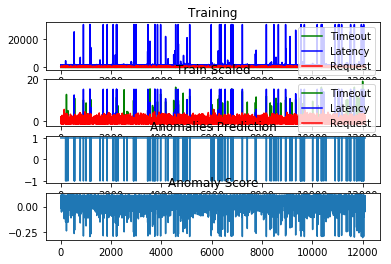

In [21]:
plt.subplot(411)
plt.plot(range(len(train_data)),train_data['timeout'], color='g', label='Timeout')
plt.plot(range(len(train_data)),train_data['latency'], color='b', label='Latency')
plt.plot(range(len(train_data)),train_data['request'], color='r', label='Request')
plt.legend(loc = 'upper right')
plt.title('Training')

plt.subplot(412)
plt.plot(range(len(X_train)),X_train['timeout'], color='g', label='Timeout')
plt.plot(range(len(X_train)),X_train['latency'], color='b', label='Latency')
plt.plot(range(len(X_train)),X_train['request'], color='r', label='Request')
plt.legend(loc = 'upper right')
plt.title('Train Scaled')

plt.subplot(413)
plt.plot(range(len(anomaly_predict_train)),anomaly_predict_train)
plt.title('Anomalies Prediction')

plt.subplot(414)
plt.plot(range(len(anomaly_score_train)),anomaly_score_train)
plt.title('Anomaly Score')
plt.show() 

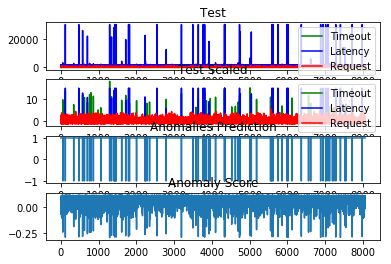

In [22]:
plt.subplot(411)
plt.plot(range(len(test_data)),test_data['timeout'], color='g', label='Timeout')
plt.plot(range(len(test_data)),test_data['latency'], color='b', label='Latency')
plt.plot(range(len(test_data)),test_data['request'], color='r', label='Request')
plt.legend(loc = 'upper right')
plt.title('Test')

plt.subplot(412)
plt.plot(range(len(X_test)),X_test['timeout'], color='g', label='Timeout')
plt.plot(range(len(X_test)),X_test['latency'], color='b', label='Latency')
plt.plot(range(len(X_test)),X_test['request'], color='r', label='Request')
plt.legend(loc = 'upper right')
plt.title('Test Scaled')

plt.subplot(413)
plt.plot(range(len(anomaly_predict_test)),anomaly_predict_test)
plt.title('Anomalies Prediction')

plt.subplot(414)
plt.plot(range(len(anomaly_predict_test)),anomaly_score_test)
plt.title('Anomaly Score')
plt.show() 

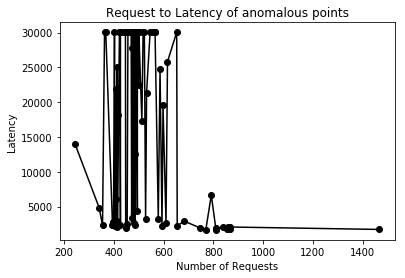

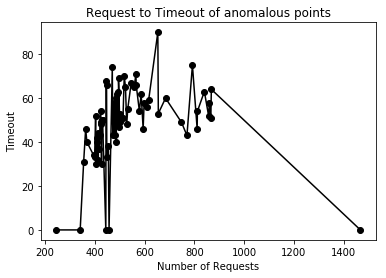

In [23]:
anomalies = test_data.loc[test_data['anomaly'] == -1]

anomalies = anomalies.sort_values('request')

x = anomalies['request']
y = anomalies['latency']
plt.xlabel('Number of Requests')
plt.ylabel('Latency')
plt.title('Request to Latency of anomalous points')
plt.plot(x, y, '-ok')
plt.show()

y = anomalies['timeout']
plt.xlabel('Number of Requests')
plt.ylabel('Timeout')
plt.title('Request to Timeout of anomalous points')
plt.plot(x, y, '-ok')
plt.show()